In [1]:
%%configure -f 
{"executorMemory": "12G", "executorCores": 6}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
10,None,pyspark,idle,,,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6,None,pyspark,idle,,,None,
10,None,pyspark,idle,,,None,✔


In [47]:
from typing import List

from pyspark import SparkFiles
from subprocess import call
import sys


def install_deps(deps: List[str]) -> None:
    call([sys.executable, '-m', 'pip', 'install', '-q', '-t', SparkFiles.getRootDirectory(), *deps])


install_deps(['numpy', 'matplotlib', 'pandas', 'scipy', 'seaborn'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
distance_calculation_df = (
    spark
    .read
    .format("mongodb")
    .option("database", "enhancer3d")
    .option("collection", "distance_calculation")
    .option("partitioner", "com.mongodb.spark.sql.connector.read.partitioner.SamplePartitioner")
    .option("partitioner.options.partition.field", "_id")
    .option("partitioner.options.samples.per.partition", "2")
    .load()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
from pyspark.sql import functions as F, types as T
import numpy as np

@F.udf(T.ArrayType(T.DoubleType()))
def diff(A, B):
    return np.abs(np.array(A) - np.array(B)).tolist()

@F.udf(T.DoubleType())
def var(A):
    return float(np.var(A))

@F.udf(T.DoubleType())
def avg(A):
    return float(np.mean(A))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# cell_line_1 = 'GM12878'
# cell_line_2 = 'HFFC6'
# species = 'Nean'

gm12878_neanderthal_df_ref = (
    distance_calculation_df
    .select('_id.*', '*')
    .drop('_id')
    .where(F.col('project_id') == '8k_models_project_GM12878')
    .where(F.col('ensemble_id').startswith('models3D_GM12878_Nean_models3D_GM12878_Nean_results'))
    .cache()
    .alias("ref")
)

gm12878_neanderthal_df_mod = (
    distance_calculation_df
    .select('_id.*', '*')
    .drop('_id')
    .where(F.col('project_id') == '8k_models_project_GM12878')
    .where(F.col('ensemble_id').startswith('models3D_GM12878_Nean_models3D_GM12878_Nean_mod_results'))
    .cache()
    .alias("mod")
)

hffc6_neanderthal_df_ref = (
    distance_calculation_df
    .select('_id.*', '*')
    .drop('_id')
    .where(F.col('project_id') == '8k_models_project_HFFC6')
    .where(F.col('ensemble_id').startswith('models3D_HFFC6_Nean_models3D_HFFC6_Nean_results'))
    .cache()
    .alias("ref")
)

hffc6_neanderthal_df_mod = (
    distance_calculation_df
    .select('_id.*', '*')
    .drop('_id')
    .where(F.col('project_id') == '8k_models_project_HFFC6')
    .where(F.col('ensemble_id').startswith('models3D_HFFC6_Nean_models3D_HFFC6_Nean_mod_results'))
    .cache()
    .alias("mod")
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
%%pretty
gm12878_neanderthal_df_mod.show(n=1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

project_id,ensemble_id,region_id,gene_id,enh_id,avg_dist,dist,enh_center_pos,enh_center_position,enh_chr,enh_end,enh_loci,enh_model_coloring_end,enh_model_coloring_start,enh_model_position,enh_score,enh_start,enh_tSS_distance,gene_TSS_pos,gene_chr,gene_end,gene_model_coloring_end,gene_model_coloring_start,gene_model_position,gene_start,gene_strand,number_bins,project_author,project_authors,project_cell_line,project_cell_lines,project_executed_at,project_species,region_chr,region_end,region_start,var_dist
8k_models_project...,models3D_GM12878_...,chr10:10300866-12...,ENSG00000065665.21,chr10:10854747-10...,31.984159469604492,[19.0284652709960...,10848425,10848425,chr10,10848800,chr10:10848050-10...,178,178,178,8.12594160720854,10848050,1276440,12124865,chr10,12165190,1495,1454,1454,12124865,+,100,NULL,"[Nikita Kozlov, M...",NULL,[GM12878],2025-04-06 18:29:...,"[Denisovans, Nean...",chr10,12302793,10300866,73.06163787841797


In [17]:
gm12878_neanderthal_df_ref_joined_with_mod = (
    gm12878_neanderthal_df_ref
    .join(
        gm12878_neanderthal_df_mod,
        on=['region_id', 'gene_id', 'enh_id'],
        how='inner'
    )
    .select(
        'region_id',
        'gene_id',
        'enh_id',

        F.col('ref.enh_score').alias('enh_score'),

        F.col('ref.dist').alias('ref_dist'),
        F.col('ref.avg_dist').alias('ref_dist_avg'),
        var(F.col('ref.dist')).alias('ref_dist_var'),

        F.col('mod.dist').alias('mod_dist'),
        F.col('mod.avg_dist').alias('mod_dist_avg'),
        var(F.col('mod.dist')).alias('mod_dist_var'),

        diff(F.col('ref.dist'), F.col('mod.dist')).alias('dist_diff'),
        avg(F.col('dist_diff')).alias('dist_diff_avg'),
        var(F.col('dist_diff')).alias('dist_diff_var')
    )
    .cache()
)

hffc6_neanderthal_df_ref_joined_with_mod = (
    hffc6_neanderthal_df_ref
    .join(
        hffc6_neanderthal_df_mod,
        on=['region_id', 'gene_id', 'enh_id'],
        how='inner'
    )
    .select(
        'region_id',
        'gene_id',
        'enh_id',

        F.col('ref.dist').alias('ref_dist'),
        F.col('ref.avg_dist').alias('ref_dist_avg'),
        var(F.col('ref.dist')).alias('ref_dist_var'),

        F.col('mod.dist').alias('mod_dist'),
        F.col('mod.avg_dist').alias('mod_dist_avg'),
        var(F.col('mod.dist')).alias('mod_dist_var'),

        diff(F.col('ref.dist'), F.col('mod.dist')).alias('dist_diff'),
        avg(F.col('dist_diff')).alias('dist_diff_avg'),
        var(F.col('dist_diff')).alias('dist_diff_var')
    )
    .cache()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
%%pretty
gm12878_neanderthal_df_ref_joined_with_mod.show(n=1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

region_id,gene_id,enh_id,enh_score,ref_dist,ref_dist_avg,ref_dist_var,mod_dist,mod_dist_avg,mod_dist_var,dist_diff,dist_diff_avg,dist_diff_var
chr10:10300866-12...,ENSG00000134463.15,chr10:10854747-10...,8.12594160720854,[37.4842910766601...,29.35211753845215,28.274041876941432,[43.9818611145019...,30.494966506958008,40.37835280515713,[6.49757003784179...,6.482598838806152,24.76725998946048


In [43]:
gm12878_neanderthal_genes_with_average_distance_df = (
    gm12878_neanderthal_df_ref_joined_with_mod
    .select(
        'region_id',
        'gene_id',
        'enh_id',
        'ref_dist',
        'mod_dist',
        'dist_diff_avg'
    )
    # group by gene and take average of distances
    .groupBy('gene_id')
    .agg(
        F.avg('dist_diff_avg').alias('dist_diff_avg')
    )
    .orderBy(F.desc('dist_diff_avg'))
    .alias("gm12878")
)

hffc6_neanderthal_genes_with_average_distance_df = (
    hffc6_neanderthal_df_ref_joined_with_mod
    .select(
        'region_id',
        'gene_id',
        'enh_id',
        'ref_dist',
        'mod_dist',
        'dist_diff_avg'
    )
    # group by gene and take average of distances
    .groupBy('gene_id')
    .agg(
        F.avg('dist_diff_avg').alias('dist_diff_avg')
    )
    .orderBy(F.desc('dist_diff_avg'))
    .alias("hffc6")
)

gm12878_hffc6_neanderthal_top_100_genes_with_biggest_distance_difference_df = (
    gm12878_neanderthal_genes_with_average_distance_df
    .join(
        hffc6_neanderthal_genes_with_average_distance_df,
        on=['gene_id'],
        how='inner'
    )
    .select(
        'gene_id',
        F.col('gm12878.dist_diff_avg').alias('dist_diff_avg_gm12878'),
        F.col('hffc6.dist_diff_avg').alias('dist_diff_avg_hffc6'),
        F.abs((F.col('gm12878.dist_diff_avg') - F.col('hffc6.dist_diff_avg'))).alias('dist_diff_avg'),
    )
    .orderBy(F.desc('dist_diff_avg'))
    .limit(100)
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
%%pretty
gm12878_hffc6_neanderthal_top_100_genes_with_biggest_distance_difference_df.show(n=5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

gene_id,dist_diff_avg_gm12878,dist_diff_avg_hffc6,dist_diff_avg
ENSG00000257743.9,5.008305636843046,26.965232073664666,21.956926436821618
ENSG00000257138.1,1.7663951730293534,23.32807148337364,21.56167631034429
ENSG00000258227.7,1.9520897436141968,20.145277091264724,18.19318734765053
ENSG00000201761.1,15.903088303937253,2.5249676450595127,13.37812065887774
ENSG00000211698.2,14.431525308871477,1.3924398446083068,13.03908546426317


In [45]:
# to pandas and plot
import pandas as pd

gm12878_hffc6_neanderthal_top_100_genes_with_biggest_distance_difference_df_pd = (
    gm12878_hffc6_neanderthal_top_100_genes_with_biggest_distance_difference_df
    .toPandas()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(15, 10))
sns.barplot(x='gene_id', y='dist_diff_avg', data=gm12878_hffc6_neanderthal_top_100_genes_with_biggest_distance_difference_df_pd)
plt.xticks(rotation=90)

plt.xlabel('Gene ID')
plt.ylabel('Distance Difference')

plt.title('Top 100 Genes with Biggest Distance Difference between GM12878 and HFFC6 Neanderthal')

plt.tight_layout()
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

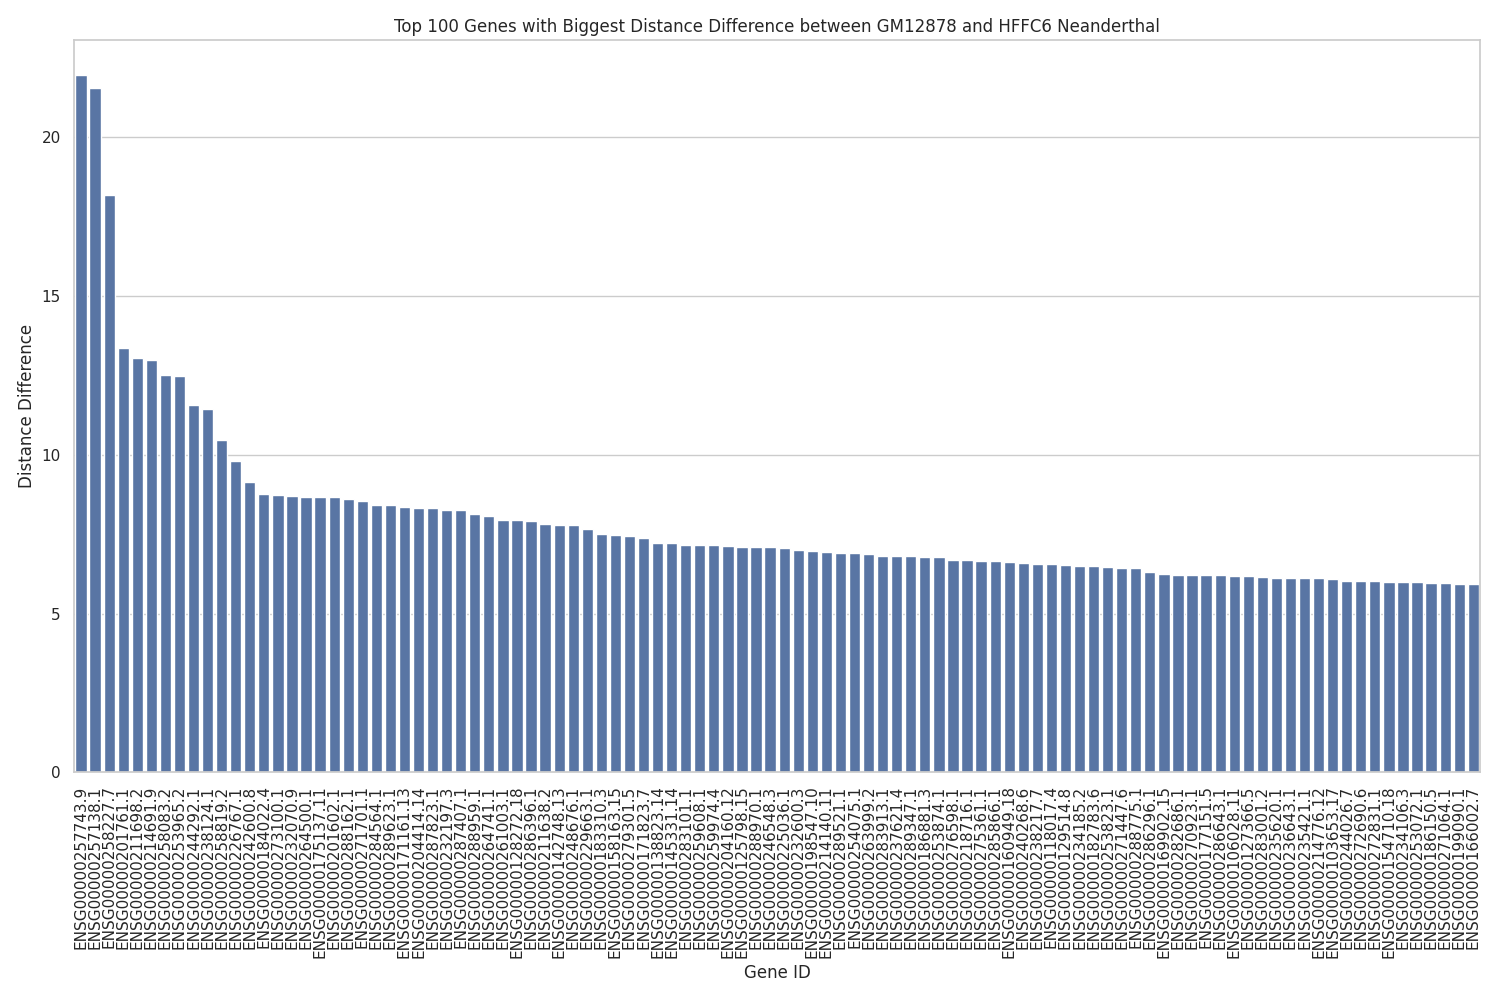

In [52]:
%matplot plt